📂 Working Directory: c:\Users\teres\Desktop\MRI_GAN_Project\mri-gan-project\notebooks
🚀 Project Root added: c:\Users\teres\Desktop\MRI_GAN_Project\mri-gan-project
✅ Module 'src' imported successfully!

🧠 Initializing Generator on cpu...
No checkpoint directory found at: c:\Users\teres\Desktop\MRI_GAN_Project\mri-gan-project\results/checkpoints
   (Using random weights - you will see only static noise)


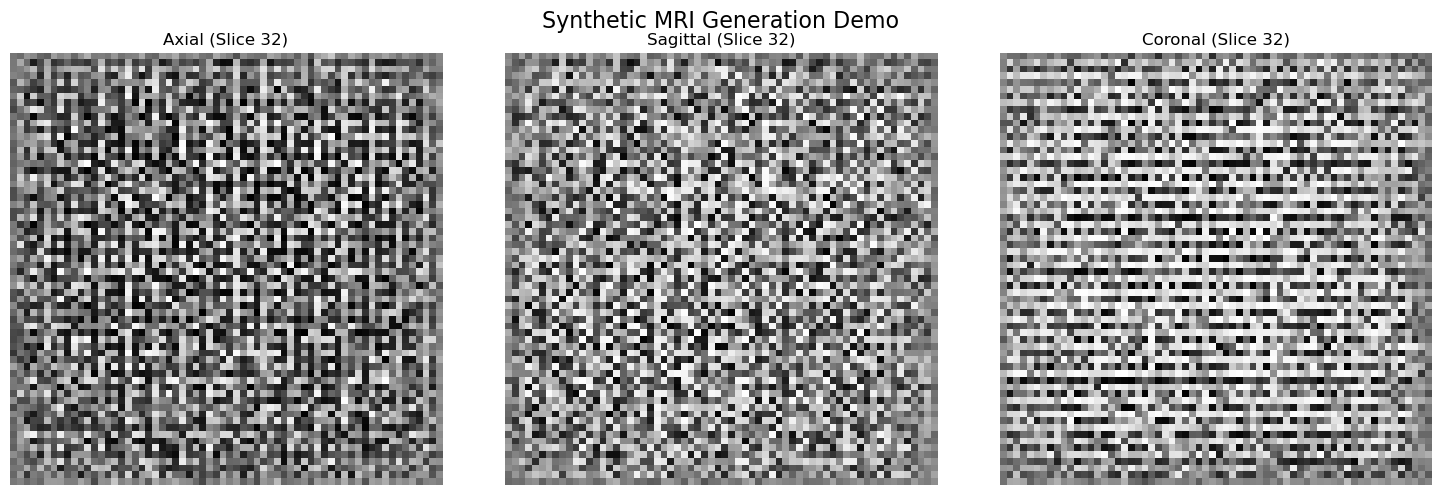

✅ Visualization complete. Volume shape: (64, 64, 64)


In [4]:
# -*- coding: utf-8 -*-
"""
Author: Teresa Zorzi
Date: January 2026
Description: Demo Notebook to generate and visualize synthetic MRI brain scans.
"""

import torch
import matplotlib.pyplot as plt
import sys
import os
import glob

# --- PATH SETUP  ---
# Obtain  the folder where this notebook is located (e.g., .../MRI_GAN_Project/notebooks)
current_dir = os.getcwd()

# Go up one level to find the project root (e.g., .../MRI_GAN_Project)
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the root to Python path so it can see 'src'
if project_root not in sys.path:
    sys.path.append(project_root)

# Debug check
print(f"📂 Working Directory: {current_dir}")
print(f"🚀 Project Root added: {project_root}")

# --- IMPORTS ---
try:
    from src.models import CPUOptimizedGenerator3D
    print("✅ Module 'src' imported successfully!")
except ImportError as e:
    print("\n CRITICAL ERROR: Python still can't find 'src'.")
    print("Make sure the folder structure is:")
    print("  MRI_GAN_Project/")
    print("  ├── src/")
    print("  └── notebooks/ (where you are now)")
    raise e

# --- CONFIGURATION & COMMANDS ---
%matplotlib inline

def load_latest_checkpoint(model, checkpoint_dir):
    """
    Searches for the latest .pth file in the checkpoint directory 
    and loads it into the model.
    """
    # Use project_root to build the absolute path to results
    full_checkpoint_dir = os.path.join(project_root, checkpoint_dir)
    
    if not os.path.exists(full_checkpoint_dir):
        print(f"No checkpoint directory found at: {full_checkpoint_dir}")
        print("   (Using random weights - you will see only static noise)")
        return model

    # Find all .pth files
    list_of_files = glob.glob(os.path.join(full_checkpoint_dir, '*.pth'))
    
    if not list_of_files:
        print("No .pth files found. Using random weights.")
        return model

    # Get the latest file based on creation time
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(f"🔄 Loading weights from: {os.path.basename(latest_file)}")
    try:
        # Load to CPU
        model.load_state_dict(torch.load(latest_file, map_location=torch.device('cpu')))
        print("✅ Weights loaded successfully!")
    except Exception as e:
        print(f"⚠️  Error loading weights: {e}")
    
    return model

def show_generated_brain():
    # 1. Configuration
    LATENT_DIM = 64
    device = torch.device("cpu") # Safe for visualization
    
    print(f"\n🧠 Initializing Generator on {device}...")

    # 2. Initialize Model & Load Weights
    netG = CPUOptimizedGenerator3D(latent_dim=LATENT_DIM).to(device)
    # Note: the path is relative to the project root
    netG = load_latest_checkpoint(netG, "results/checkpoints")
    netG.eval() 
    
    # 3. Generate Random Input
    z = torch.randn(1, LATENT_DIM).to(device) 
    fake_label = torch.tensor([0], dtype=torch.long).to(device) # Class 0
    
    # 4. Generate Volume
    with torch.no_grad():
        fake_brain = netG(z, fake_label).squeeze().numpy() 
    
    # 5. Visualize (Axial, Sagittal, Coronal)
    depth, height, width = fake_brain.shape
    mid_d, mid_h, mid_w = depth // 2, height // 2, width // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Axial
    axes[0].imshow(fake_brain[mid_d, :, :], cmap='gray')
    axes[0].set_title(f"Axial (Slice {mid_d})")
    axes[0].axis('off')
    
    # Sagittal
    axes[1].imshow(fake_brain[:, mid_h, :], cmap='gray')
    axes[1].set_title(f"Sagittal (Slice {mid_h})")
    axes[1].axis('off')
    
    # Coronal
    axes[2].imshow(fake_brain[:, :, mid_w], cmap='gray')
    axes[2].set_title(f"Coronal (Slice {mid_w})")
    axes[2].axis('off')
    
    plt.suptitle("Synthetic MRI Generation Demo", fontsize=16)
    plt.tight_layout()
    plt.show()
    print(f"✅ Visualization complete. Volume shape: {fake_brain.shape}")

# Run directly
show_generated_brain()